# 資料讀取與整合
* 數據路徑與對應標籤（正常=0 / 異常=1）

In [235]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold  # [修改點] 使用交叉驗證

In [236]:
# torch.manual_seed(1)  # 固定種子

# 圖片要儲存到哪個資料夾
result_dir = "result"
os.makedirs(result_dir, exist_ok=True)

# 正常資料夾 & 異常資料夾
normal_dir = "dataset/normal"
abnormal_dir = "dataset/abnormal"

MAX_SEQ_LEN = 10  # 期望的固定序列長度

all_sequences = []
all_labels = []

def process_file(file_path, label):
    """
    讀取 CSV 檔案並切分為 CHUNK_SIZE 的小段。
    :param file_path: 檔案路徑
    :param label: 該檔案的標籤 (0: 正常, 1: 異常)
    """
    df = pd.read_csv(file_path)
    
    # 假設有 'current', 'voltage', 'power' 三欄
    current = df['current'].values  # shape: (N,)
    voltage = df['voltage'].values
    power   = df['power'].values
    
    # 組合特徵維度: (N, 3)
    sequence = np.column_stack((current, voltage, power))
    seq_len = sequence.shape[0]
    
    # 將數據切分為 CHUNK_SIZE 的小段
    num_chunks = seq_len // MAX_SEQ_LEN
    for i in range(num_chunks):
        start = i * MAX_SEQ_LEN
        end = start + MAX_SEQ_LEN
        chunk = sequence[start:end]
        all_sequences.append(chunk)
        all_labels.append(label)


# === 1) 讀取 normal 資料夾的 CSV，標籤=0 ===
for filename in os.listdir(normal_dir):
    if filename.lower().endswith(".csv"):
        file_path = os.path.join(normal_dir, filename)
        process_file(file_path, label=0)

# === 2) 讀取 abnormal 資料夾的 CSV，標籤=1 ===
for filename in os.listdir(abnormal_dir):
    if filename.lower().endswith(".csv"):
        file_path = os.path.join(abnormal_dir, filename)
        process_file(file_path, label=1)
        
# 轉為 numpy array
all_sequences = np.array(all_sequences, dtype=np.float32)  # shape: (num_samples, 30, 3)
all_labels = np.array(all_labels, dtype=np.int64)          # shape: (num_samples,)

print("all_sequences shape:", all_sequences.shape)
print("all_labels shape:", all_labels.shape)
print("Number of normal samples:", np.sum(all_labels == 0))
print("Number of abnormal samples:", np.sum(all_labels == 1))

all_sequences shape: (60, 10, 3)
all_labels shape: (60,)
Number of normal samples: 33
Number of abnormal samples: 27


# 自訂 Dataset 與 DataLoader

In [237]:
class ChargingDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences  # shape: (num_samples, 30, 3)
        self.labels = labels        # shape: (num_samples,)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx]    # (30, 3)
        y = self.labels[idx]       # 0 or 1
        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        return x_tensor, y_tensor
# # 切分 train / test (80% / 20%)
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# batch_size = 2  # 可以保留2, 不會再出現 shape mismatch

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# LSTM模型
輸入(voltage, current, power) 
輸出(normal / abnormal)

In [238]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes=2):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        # x: (batch_size, seq_len, input_dim) 可能在 GPU (cuda) 或 CPU
        batch_size = x.size(0)

        # h0: , c0: Initialize cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # out: (batch_size, seq_len, hidden_dim)
        
        out = out[:, -1, :]  # 取最後時刻的輸出 (batch_size, hidden_dim)
        out = self.fc(out)   # (batch_size, num_classes)
        return out


# K-fold Cross Validation

In [239]:
dataset = ChargingDataset(all_sequences, all_labels)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_dim = 3       # current, voltage, power
hidden_dim = 16     # LSTM hidden state
num_layers = 2      # LSTM層數
num_classes = 2     # 二元分類
learning_rate = 1e-4
num_epochs = 50
batch_size = 2

In [240]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * x_batch.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = running_loss / total
    avg_acc = correct / total if total > 0 else 0
    return avg_loss, avg_acc


# K-fold 訓練


=== Fold 1 / 5 ===
Epoch 1/50 | TrainLoss: 0.6987, TrainAcc: 0.46 | TestLoss: 0.7007, TestAcc: 0.42
Epoch 2/50 | TrainLoss: 0.6976, TrainAcc: 0.46 | TestLoss: 0.6999, TestAcc: 0.42
Epoch 3/50 | TrainLoss: 0.6971, TrainAcc: 0.46 | TestLoss: 0.6994, TestAcc: 0.42
Epoch 4/50 | TrainLoss: 0.6967, TrainAcc: 0.46 | TestLoss: 0.6986, TestAcc: 0.42
Epoch 5/50 | TrainLoss: 0.6960, TrainAcc: 0.46 | TestLoss: 0.6975, TestAcc: 0.42
Epoch 6/50 | TrainLoss: 0.6956, TrainAcc: 0.46 | TestLoss: 0.6963, TestAcc: 0.42
Epoch 7/50 | TrainLoss: 0.6949, TrainAcc: 0.46 | TestLoss: 0.6958, TestAcc: 0.42
Epoch 8/50 | TrainLoss: 0.6947, TrainAcc: 0.46 | TestLoss: 0.6949, TestAcc: 0.42
Epoch 9/50 | TrainLoss: 0.6945, TrainAcc: 0.46 | TestLoss: 0.6942, TestAcc: 0.42
Epoch 10/50 | TrainLoss: 0.6945, TrainAcc: 0.46 | TestLoss: 0.6943, TestAcc: 0.42
Epoch 11/50 | TrainLoss: 0.6936, TrainAcc: 0.42 | TestLoss: 0.6934, TestAcc: 0.50
Epoch 12/50 | TrainLoss: 0.6935, TrainAcc: 0.48 | TestLoss: 0.6926, TestAcc: 0.58
Epoch

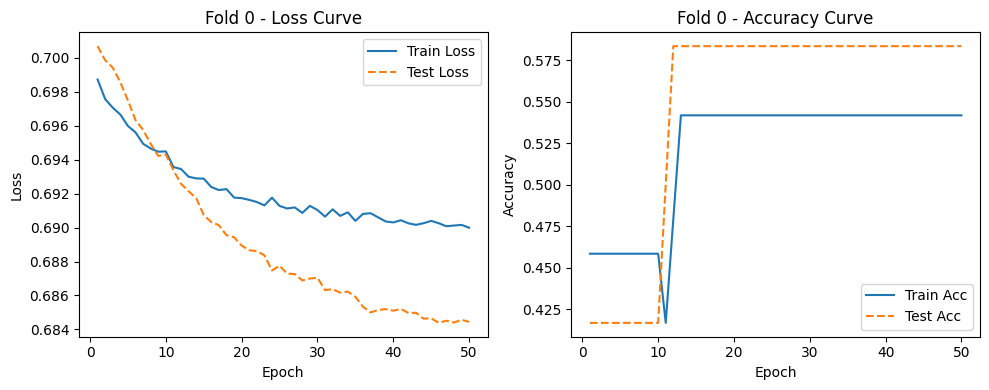

<Figure size 400x400 with 0 Axes>

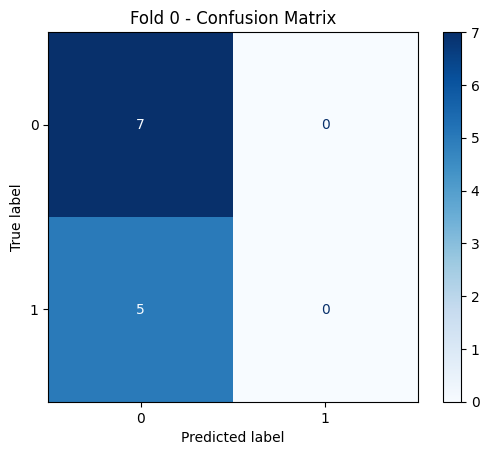


=== Fold 2 / 5 ===
Epoch 1/50 | TrainLoss: 0.7139, TrainAcc: 0.46 | TestLoss: 0.7253, TestAcc: 0.42
Epoch 2/50 | TrainLoss: 0.7111, TrainAcc: 0.46 | TestLoss: 0.7236, TestAcc: 0.42
Epoch 3/50 | TrainLoss: 0.7099, TrainAcc: 0.46 | TestLoss: 0.7217, TestAcc: 0.42
Epoch 4/50 | TrainLoss: 0.7084, TrainAcc: 0.46 | TestLoss: 0.7194, TestAcc: 0.42
Epoch 5/50 | TrainLoss: 0.7071, TrainAcc: 0.46 | TestLoss: 0.7176, TestAcc: 0.42
Epoch 6/50 | TrainLoss: 0.7053, TrainAcc: 0.46 | TestLoss: 0.7161, TestAcc: 0.42
Epoch 7/50 | TrainLoss: 0.7042, TrainAcc: 0.46 | TestLoss: 0.7142, TestAcc: 0.42
Epoch 8/50 | TrainLoss: 0.7030, TrainAcc: 0.46 | TestLoss: 0.7126, TestAcc: 0.42
Epoch 9/50 | TrainLoss: 0.7021, TrainAcc: 0.46 | TestLoss: 0.7112, TestAcc: 0.42
Epoch 10/50 | TrainLoss: 0.7009, TrainAcc: 0.46 | TestLoss: 0.7095, TestAcc: 0.42
Epoch 11/50 | TrainLoss: 0.6998, TrainAcc: 0.46 | TestLoss: 0.7086, TestAcc: 0.42
Epoch 12/50 | TrainLoss: 0.6990, TrainAcc: 0.46 | TestLoss: 0.7070, TestAcc: 0.42
Epoch

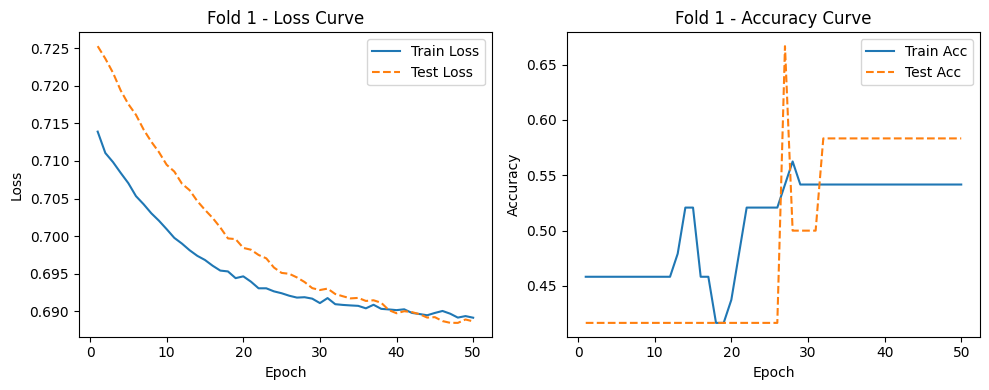

<Figure size 400x400 with 0 Axes>

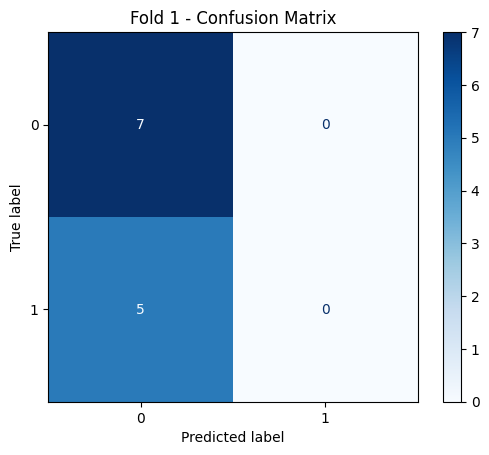


=== Fold 3 / 5 ===
Epoch 1/50 | TrainLoss: 0.6904, TrainAcc: 0.54 | TestLoss: 0.6880, TestAcc: 0.58
Epoch 2/50 | TrainLoss: 0.6900, TrainAcc: 0.54 | TestLoss: 0.6879, TestAcc: 0.58
Epoch 3/50 | TrainLoss: 0.6908, TrainAcc: 0.54 | TestLoss: 0.6874, TestAcc: 0.58
Epoch 4/50 | TrainLoss: 0.6898, TrainAcc: 0.54 | TestLoss: 0.6875, TestAcc: 0.58
Epoch 5/50 | TrainLoss: 0.6904, TrainAcc: 0.54 | TestLoss: 0.6871, TestAcc: 0.58
Epoch 6/50 | TrainLoss: 0.6898, TrainAcc: 0.54 | TestLoss: 0.6871, TestAcc: 0.58
Epoch 7/50 | TrainLoss: 0.6897, TrainAcc: 0.54 | TestLoss: 0.6870, TestAcc: 0.58
Epoch 8/50 | TrainLoss: 0.6897, TrainAcc: 0.54 | TestLoss: 0.6871, TestAcc: 0.58
Epoch 9/50 | TrainLoss: 0.6897, TrainAcc: 0.54 | TestLoss: 0.6870, TestAcc: 0.58
Epoch 10/50 | TrainLoss: 0.6896, TrainAcc: 0.54 | TestLoss: 0.6869, TestAcc: 0.58
Epoch 11/50 | TrainLoss: 0.6897, TrainAcc: 0.54 | TestLoss: 0.6867, TestAcc: 0.58
Epoch 12/50 | TrainLoss: 0.6895, TrainAcc: 0.54 | TestLoss: 0.6866, TestAcc: 0.58
Epoch

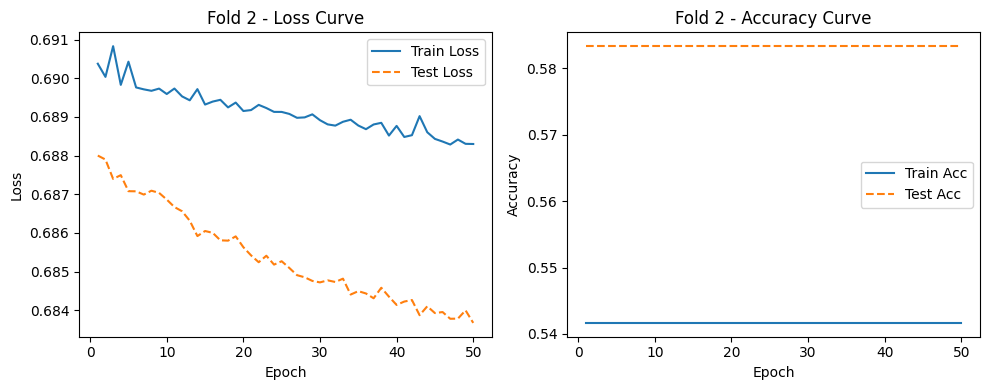

<Figure size 400x400 with 0 Axes>

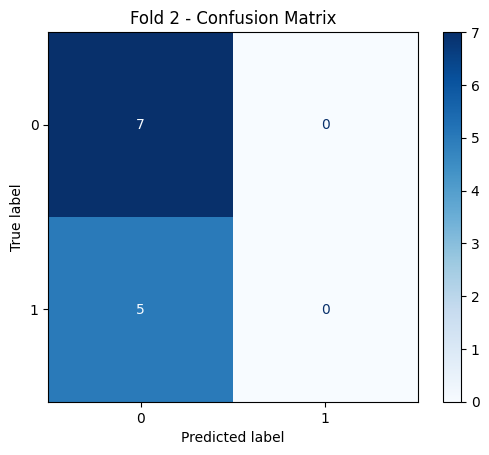


=== Fold 4 / 5 ===
Epoch 1/50 | TrainLoss: 0.7009, TrainAcc: 0.44 | TestLoss: 0.6928, TestAcc: 0.50
Epoch 2/50 | TrainLoss: 0.6994, TrainAcc: 0.44 | TestLoss: 0.6924, TestAcc: 0.50
Epoch 3/50 | TrainLoss: 0.6981, TrainAcc: 0.44 | TestLoss: 0.6920, TestAcc: 0.50
Epoch 4/50 | TrainLoss: 0.6969, TrainAcc: 0.44 | TestLoss: 0.6916, TestAcc: 0.50
Epoch 5/50 | TrainLoss: 0.6963, TrainAcc: 0.44 | TestLoss: 0.6912, TestAcc: 0.50
Epoch 6/50 | TrainLoss: 0.6946, TrainAcc: 0.44 | TestLoss: 0.6911, TestAcc: 0.50
Epoch 7/50 | TrainLoss: 0.6940, TrainAcc: 0.44 | TestLoss: 0.6909, TestAcc: 0.50
Epoch 8/50 | TrainLoss: 0.6931, TrainAcc: 0.44 | TestLoss: 0.6908, TestAcc: 0.75
Epoch 9/50 | TrainLoss: 0.6922, TrainAcc: 0.52 | TestLoss: 0.6907, TestAcc: 0.83
Epoch 10/50 | TrainLoss: 0.6915, TrainAcc: 0.67 | TestLoss: 0.6906, TestAcc: 0.75
Epoch 11/50 | TrainLoss: 0.6907, TrainAcc: 0.60 | TestLoss: 0.6906, TestAcc: 0.50
Epoch 12/50 | TrainLoss: 0.6900, TrainAcc: 0.56 | TestLoss: 0.6905, TestAcc: 0.50
Epoch

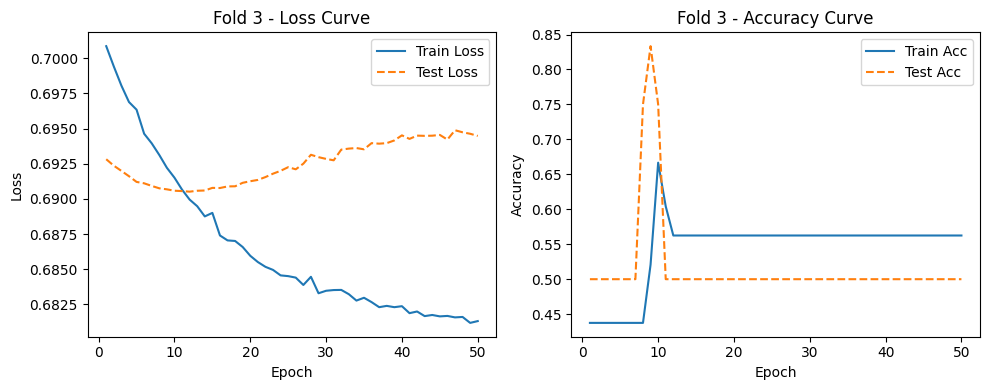

<Figure size 400x400 with 0 Axes>

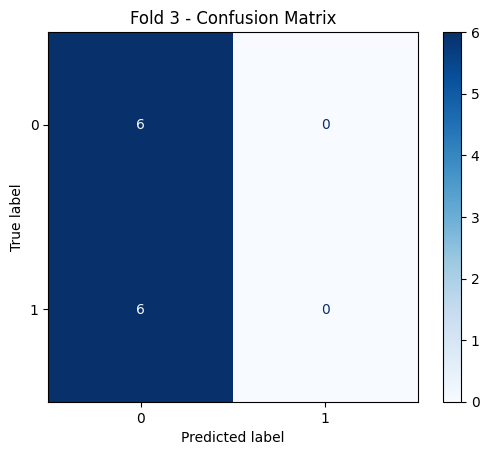


=== Fold 5 / 5 ===
Epoch 1/50 | TrainLoss: 0.6884, TrainAcc: 0.56 | TestLoss: 0.6950, TestAcc: 0.50
Epoch 2/50 | TrainLoss: 0.6881, TrainAcc: 0.56 | TestLoss: 0.6952, TestAcc: 0.50
Epoch 3/50 | TrainLoss: 0.6879, TrainAcc: 0.56 | TestLoss: 0.6954, TestAcc: 0.50
Epoch 4/50 | TrainLoss: 0.6876, TrainAcc: 0.56 | TestLoss: 0.6954, TestAcc: 0.50
Epoch 5/50 | TrainLoss: 0.6875, TrainAcc: 0.56 | TestLoss: 0.6956, TestAcc: 0.50
Epoch 6/50 | TrainLoss: 0.6876, TrainAcc: 0.56 | TestLoss: 0.6957, TestAcc: 0.50
Epoch 7/50 | TrainLoss: 0.6873, TrainAcc: 0.56 | TestLoss: 0.6959, TestAcc: 0.50
Epoch 8/50 | TrainLoss: 0.6871, TrainAcc: 0.56 | TestLoss: 0.6961, TestAcc: 0.50
Epoch 9/50 | TrainLoss: 0.6869, TrainAcc: 0.56 | TestLoss: 0.6962, TestAcc: 0.50
Epoch 10/50 | TrainLoss: 0.6869, TrainAcc: 0.56 | TestLoss: 0.6964, TestAcc: 0.50
Epoch 11/50 | TrainLoss: 0.6868, TrainAcc: 0.56 | TestLoss: 0.6964, TestAcc: 0.50
Epoch 12/50 | TrainLoss: 0.6867, TrainAcc: 0.56 | TestLoss: 0.6964, TestAcc: 0.50
Epoch

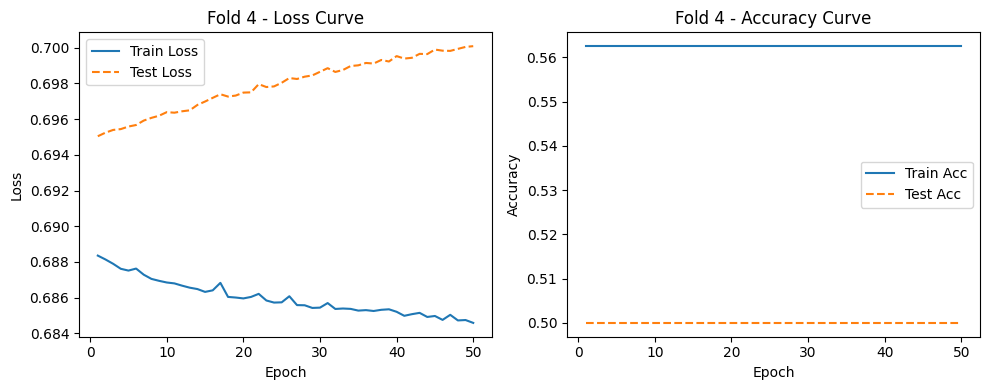

<Figure size 400x400 with 0 Axes>

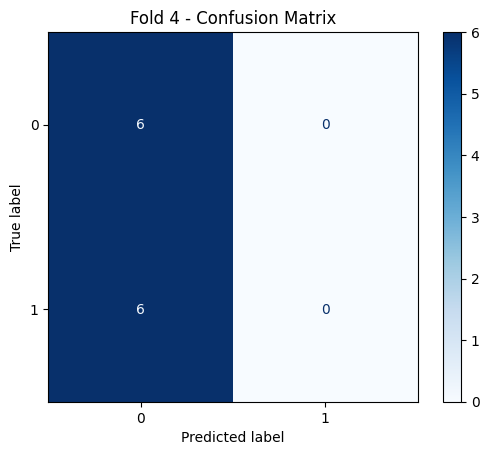

In [241]:
for fold_idx, (train_indices, test_indices) in enumerate(kfold.split(all_sequences, all_labels)):
    print(f"\n=== Fold {fold_idx+1} / {kfold.n_splits} ===")
    
    # -- 建立當前fold的 train / test data --
    train_sequences = all_sequences[train_indices]
    train_labels    = all_labels[train_indices]
    test_sequences  = all_sequences[test_indices]
    test_labels     = all_labels[test_indices]
    
    # 分別做成 Dataset
    train_dataset = ChargingDataset(train_sequences, train_labels)
    test_dataset  = ChargingDataset(test_sequences,  test_labels)
    
    # 建立 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    
    # 每個 fold 需要新建一個 LSTM 模型並重新訓練
    model = LSTMClassifier(input_dim, hidden_dim, num_layers, num_classes).to(device)
    # class_weights = torch.tensor([1.0, 1.2], device=device)  # 假設異常類別重要性更高
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 用於記錄歷次 epoch 的 loss/acc
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    
    # === 開始訓練 (num_epochs) ===
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_batch.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        
        # epoch的 train loss/acc
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total if total>0 else 0

        
        # 接著在同一epoch，做一次 test_loader 的評估
        epoch_test_loss, epoch_test_acc = evaluate_model(model, test_loader, criterion, device)

        train_loss_list.append(epoch_train_loss)
        train_acc_list.append(epoch_train_acc)
        test_loss_list.append(epoch_test_loss)
        test_acc_list.append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"TrainLoss: {epoch_train_loss:.4f}, TrainAcc: {epoch_train_acc:.2f} | "
              f"TestLoss: {epoch_test_loss:.4f}, TestAcc: {epoch_test_acc:.2f}")
        
    
    
    epochs_range = range(1, num_epochs+1)

    plt.figure(figsize=(10,4))
    # Subplot 1: Loss
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_loss_list, label='Train Loss')
    plt.plot(epochs_range, test_loss_list, label='Test Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold_idx} - Loss Curve')
    plt.legend()

    # Subplot 2: Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_acc_list, label='Train Acc')
    plt.plot(epochs_range, test_acc_list, label='Test Acc', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold_idx} - Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    # 將這張圖存到 result/ 目錄下
    fold_curve_path = os.path.join(result_dir, f"fold_{fold_idx}_curve.png")
    plt.savefig(fold_curve_path, bbox_inches='tight')
    plt.show()

    # === 混淆矩陣 ===
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            trues.extend(y_batch.cpu().numpy())

    cm = confusion_matrix(trues, preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    # print("Confusion Matrix:")
    # print(cm)

    plt.figure(figsize=(4,4))
    disp.plot(values_format='d', cmap='Blues')
    plt.title(f"Fold {fold_idx} - Confusion Matrix")
    
    # 儲存到 result/ 目錄
    fold_cm_path = os.path.join(result_dir, f"fold_{fold_idx}_cm.png")
    plt.savefig(fold_cm_path, bbox_inches='tight')
    plt.show()